In [6]:
import os
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings('ignore')

In [3]:
def extract_features(times, mags, errors):
    features = []
    features.append(np.mean(mags))
    features.append(np.std(mags))
    features.append(np.median(mags))
    features.append(stats.skew(mags))
    features.append(stats.kurtosis(mags))
    features.append(np.max(mags) - np.min(mags))
    
    features.extend(np.percentile(mags, [5, 25, 75, 95]))
    
    mad = np.median(np.abs(mags - np.median(mags)))
    features.append(mad)
    
    weights = 1.0 / (errors + 1e-10)  
    weighted_mean = np.average(mags, weights=weights)
    features.append(weighted_mean)
    features.append(np.average((mags - weighted_mean)**2, weights=weights))  # weighted variance
    
    features.append(np.mean(errors))
    features.append(np.std(errors))
    features.append(np.median(errors))
    features.append(np.max(errors))
    
    snr = np.std(mags) / (np.mean(errors) + 1e-10)
    features.append(snr)
    
    dt = np.diff(times)
    features.append(np.mean(dt))
    features.append(np.std(dt))
    features.append(np.min(dt) if len(dt) > 0 else 0)
    features.append(np.max(dt) if len(dt) > 0 else 0)

    n = len(mags)
    if n > 1:
        normalized_mags = (mags - np.mean(mags)) / (errors + 1e-10)
        stetson_k = np.sum(np.abs(normalized_mags)) / np.sqrt(n * np.sum(normalized_mags**2))
        features.append(stetson_k)
    else:
        features.append(0)
    
    if n > 1:
        von_neumann = np.sum(np.diff(mags)**2) / ((n-1) * np.var(mags) + 1e-10)
        features.append(von_neumann)
    else:
        features.append(1)
    
    if n > 1:
        autocorr = np.corrcoef(mags[:-1], mags[1:])[0, 1] if n > 2 else 0
        features.append(autocorr if not np.isnan(autocorr) else 0)
    else:
        features.append(0)
    
    peaks, properties = find_peaks(mags, prominence=0.01)
    features.append(len(peaks))  # number of peaks
    features.append(np.mean(properties['prominences']) if len(peaks) > 0 else 0)
    
    mean_mag = np.mean(mags)
    std_mag = np.std(mags)
    if std_mag > 0:
        features.append(np.sum(np.abs(mags - mean_mag) > std_mag) / n)
        features.append(np.sum(np.abs(mags - mean_mag) > 2*std_mag) / n)
        features.append(np.sum(np.abs(mags - mean_mag) > 3*std_mag) / n)
    else:
        features.extend([0, 0, 0])
    
    if n > 1:
        slope, intercept = np.polyfit(times, mags, 1)
        features.append(slope)
        residuals = mags - (slope * times + intercept)
        features.append(np.std(residuals))
    else:
        features.extend([0, 0])
    
    features.append(n)  
    features.append(np.max(times) - np.min(times))  
    
    return np.array(features)

def train_classifier(flat_files, variable_files, problematic_files):
    flat_features = []
    variable_features = []
    problematic_features = []
    
    for file in flat_files:
        data = np.loadtxt(file)
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
        features = extract_features(data[:,0], data[:,1], data[:,2])
        flat_features.append(features)

    for file in variable_files:
        data = np.loadtxt(file)
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
        features = extract_features(data[:,0], data[:,1], data[:,2])
        variable_features.append(features)


    for file in problematic_files:
        data = np.loadtxt(file)
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
        features = extract_features(data[:,0], data[:,1], data[:,2])
        problematic_features.append(features)

    X = []
    y = []
    
    for features in flat_features:
        X.append(features)
        y.append(0)
    
    for features in variable_features:
        X.append(features)
        y.append(1)
    
    for features in problematic_features:
        X.append(features)
        y.append(2)
    
    X = np.array(X)
    y = np.array(y)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),  
        activation='relu',
        solver='adam',
        alpha=0.001,  
        batch_size='auto',
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=1000,
        shuffle=True,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        verbose=True
    )
    
    mlp.fit(X_train_scaled, y_train)
    
    train_score = mlp.score(X_train_scaled, y_train)
    test_score = mlp.score(X_test_scaled, y_test)
    
    print(f"Training accuracy: {train_score}")
    print(f"Test accuracy: {test_score}")
    
    return mlp, scaler

def classify_lightcurve(times, mags, errors, mlp, scaler):
    features = extract_features(times, mags, errors)
    features = features.reshape(1, -1)
    features_scaled = scaler.transform(features)
  
    return mlp.predict(features_scaled)[0], mlp.predict_proba(features_scaled)[0]


In [4]:
flat_files = [os.path.join('flat', f) for f in os.listdir('flat') if f.endswith('.txt')]
variable_files = [os.path.join('variable', f) for f in os.listdir('variable') if f.endswith('.txt')]
problematic_files = [os.path.join('problematic', f) for f in os.listdir('problematic') if f.endswith('.txt')]

mlp, scaler = train_classifier(flat_files, variable_files, problematic_files)

with open('lightcurve_classifier.pkl', 'wb') as f:
    pickle.dump({'mlp': mlp, 'scaler': scaler}, f)

Iteration 1, loss = 1.10926798
Validation score: 0.472222
Iteration 2, loss = 0.98147355
Validation score: 0.513889
Iteration 3, loss = 0.87863723
Validation score: 0.555556
Iteration 4, loss = 0.79899026
Validation score: 0.597222
Iteration 5, loss = 0.73803661
Validation score: 0.652778
Iteration 6, loss = 0.68851942
Validation score: 0.680556
Iteration 7, loss = 0.64239131
Validation score: 0.750000
Iteration 8, loss = 0.59862470
Validation score: 0.819444
Iteration 9, loss = 0.55689992
Validation score: 0.861111
Iteration 10, loss = 0.51905047
Validation score: 0.888889
Iteration 11, loss = 0.48390522
Validation score: 0.916667
Iteration 12, loss = 0.45153506
Validation score: 0.930556
Iteration 13, loss = 0.41991599
Validation score: 0.958333
Iteration 14, loss = 0.38967312
Validation score: 0.944444
Iteration 15, loss = 0.35989730
Validation score: 0.958333
Iteration 16, loss = 0.33237792
Validation score: 0.958333
Iteration 17, loss = 0.30584504
Validation score: 0.972222
Iterat

Predicted to be flat
flat 0.9999488454729378
variable 4.930385834279591e-06
problematic 4.622414122782477e-05


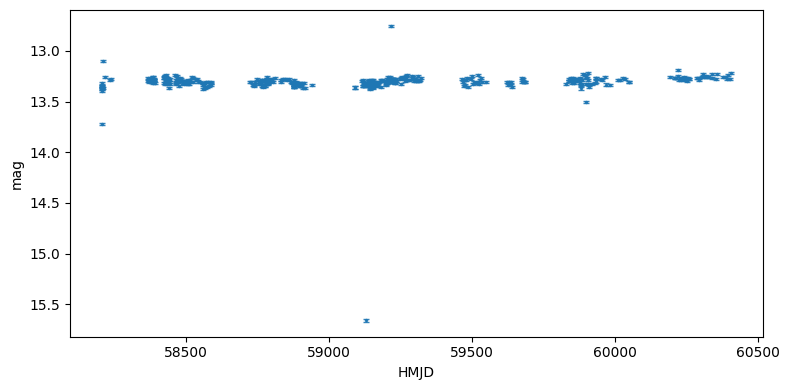

Predicted to be variable
flat 0.03499364044562613
variable 0.9607232740592343
problematic 0.004283085495139525


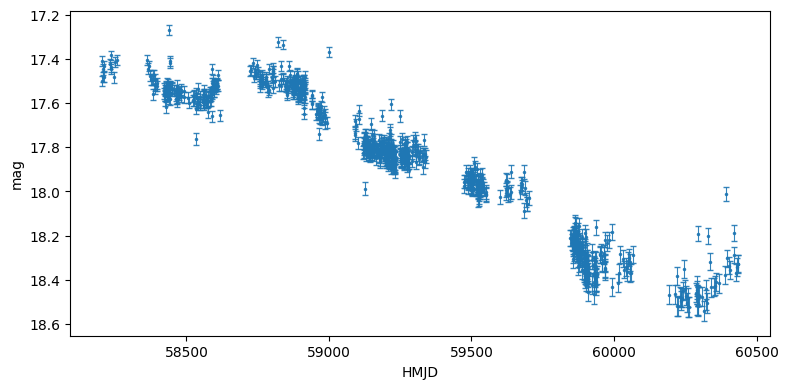

Predicted to be flat
flat 0.8662274373433847
variable 0.11945867554520331
problematic 0.014313887111411981


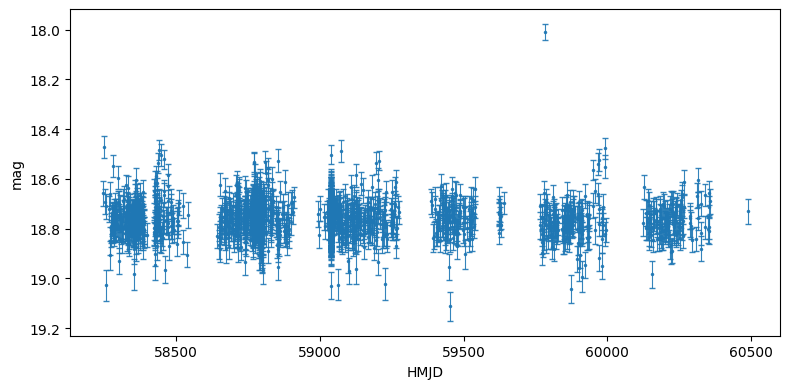

Predicted to be flat
flat 0.8162877781757577
variable 0.0008355319382749644
problematic 0.18287668988596736


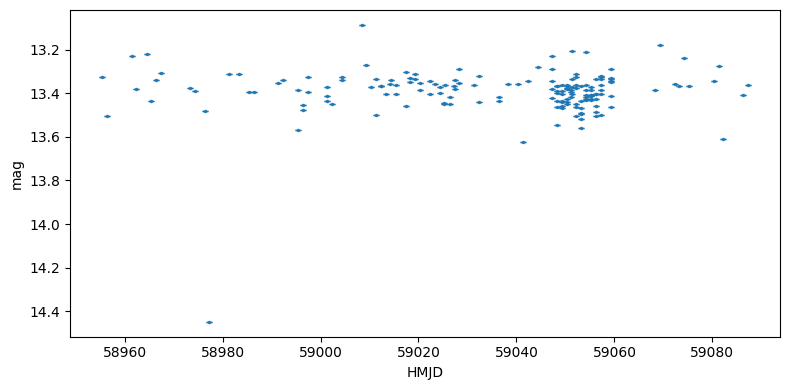

Predicted to be problematic
flat 0.01386929954328715
variable 0.015267263287508508
problematic 0.9708634371692044


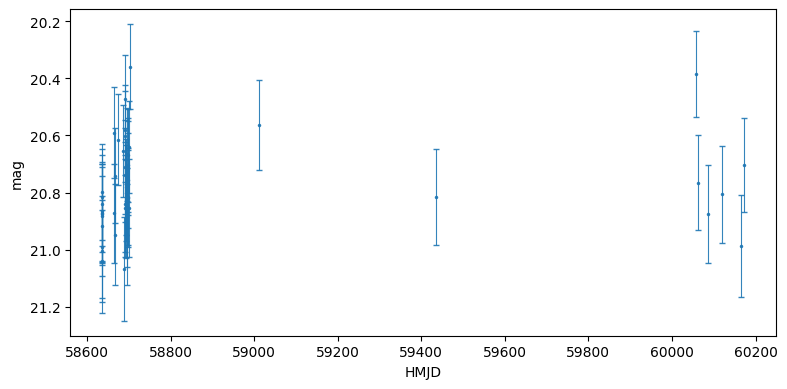

In [12]:
def test_example(filepath):
    data = np.loadtxt(test_file)
    times, mags, errors = data[:,0], data[:,1], data[:,2]

    prediction, probabilities = classify_lightcurve(times, mags, errors, mlp, scaler)
    class_names = ['flat', 'variable', 'problematic']

    print(f"Predicted to be {class_names[prediction]}")
    print(f"flat {probabilities[0]}")
    print(f"variable {probabilities[1]}") 
    print(f"problematic {probabilities[2]}")

    plt.figure(figsize=(8, 4))
    plt.errorbar(times, mags, yerr=errors, fmt='.', ms=3, lw=0.8, capsize=2, alpha=0.9)
    plt.gca().invert_yaxis() 
    plt.xlabel('HMJD')
    plt.ylabel('mag')
    #plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


test_files = [os.path.join('test', f) for f in os.listdir('test') if f.endswith('.txt')]
for test_file in test_files:
    test_example(test_file)